In [1]:
import os,sys
import pyemma
import mdtraj as md
import matplotlib.pyplot as plt
from pyemma.util.contexts import settings
import numpy as np
%matplotlib inline

In [2]:
### BOOLS ###
# save? 
SAVE = True

# random 50% subsample
BOOT = False

# quick, 1 trajectory test run
QUICK = True

# model scoring
# disabled by default due to resource requirements
score_features = False
score_msm = False

In [3]:
pdb = md.load('wt_2_4M_h2b.pdb')

In [4]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(cossin=True, periodic=True)

In [5]:
from pyemma.coordinates import load
trj_files = ['wt_2_4M_testh2b.dcd']
feat_data = load(trj_files, features = feat)

In [6]:
# SAVE
feat_name_save = f'featurized_data'
if SAVE:
    np.save(feat_name_save, feat_data)

In [7]:
### TICA ###

# parameters for calculation
dim = 4
tica_lag = 100

#feat_list = np.ndarray.tolist(feat)    
# perform tica
tica = pyemma.coordinates.tica(feat_data, dim=dim, lag=tica_lag, scaling = 'km')

# grab output
tica_getoutput = tica.get_output()

# SAVE
tica_name_save = 'tica_getoutput'
if SAVE:
    np.save(tica_name_save, tica_getoutput)

print(f'tica complete')

tica complete


In [8]:
tica_getoutput

[array([[-0.70669967, -0.67239463,  1.5785656 , -1.9234234 ],
        [-0.5948171 , -0.57466   ,  1.4539982 , -1.8663576 ],
        [-0.69332373, -0.6009678 ,  1.4367543 , -1.9503199 ],
        ...,
        [ 1.0191808 , -1.4461491 , -0.5511502 , -0.04344179],
        [ 1.0776361 , -1.4443613 , -0.6315945 , -0.01955221],
        [ 1.0659976 , -1.405108  , -0.6208521 , -0.11246798]],
       dtype=float32)]

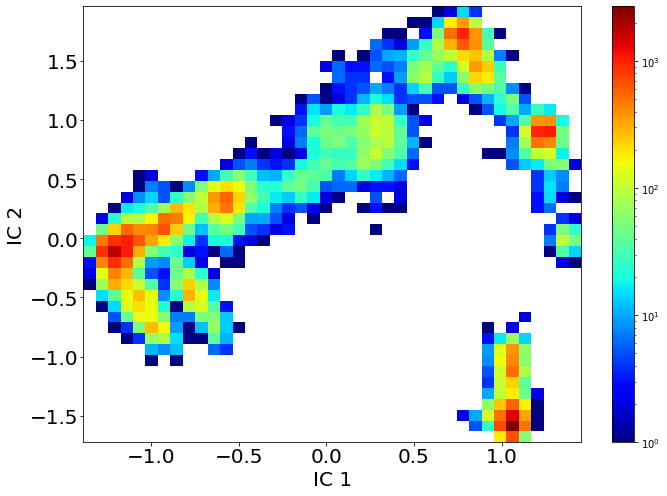

In [9]:
import pyemma
import os, sys, glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

tica_in = np.load(f'tica_getoutput.npy', allow_pickle = True)
tica_cat = np.concatenate(tica_in).T

# specify components to visualize along x and y axis
IC_x, IC_y = 0, 1

# make figure
fig, (ax0) = plt.subplots(sharey=True, sharex=True, figsize=(10, 7))
image = ax0.hist2d(tica_cat[IC_x], tica_cat[IC_y], norm=LogNorm(), bins=40, cmap = 'jet')
plt.xlabel('IC 1', fontsize=20)
plt.ylabel('IC 2', fontsize=20)
cbar = plt.colorbar(image[3], ax=ax0)
ax0.tick_params(labelsize=20, pad=1)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.savefig('WT_2_4M_density_IC_h2b.svg', format="svg",transparent=True, dpi = 600)
fig.tight_layout()
plt.show()


<Figure size 1440x720 with 0 Axes>

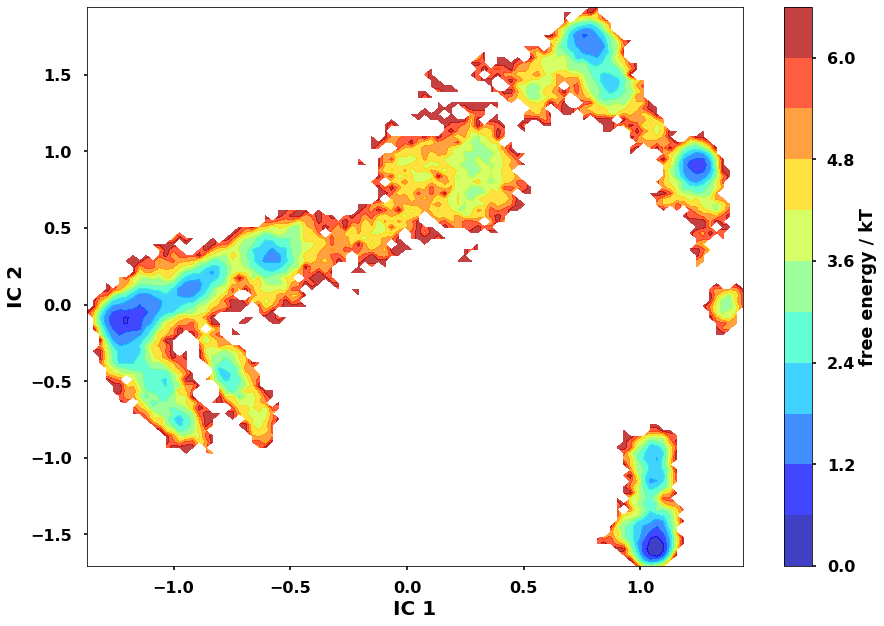

In [10]:
import pyemma
import os, sys, glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
plt.style.use('seaborn-poster')
tica_in = np.load(f'tica_getoutput.npy', allow_pickle = True)
tica_cat = np.concatenate(tica_in).T

# specify components to visualize along x and y axis
IC_x, IC_y = 0, 1

# make figure
plt.figure(figsize=(20,10)) 

plot = pyemma.plots.plot_free_energy(tica_cat[IC_x], tica_cat[IC_y], cmap='jet', ncontours=10, alpha=0.75)
plt.xlabel('IC 1', fontsize=20)
plt.ylabel('IC 2', fontsize=20)
ax0.tick_params(labelsize=20, pad=1)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.savefig('WT_2_4M_FES_IC_h2b.svg', format="svg",transparent=True, dpi = 600)
plt.tight_layout()
plt.show()


initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

(100, 4)


<Figure size 360x360 with 0 Axes>

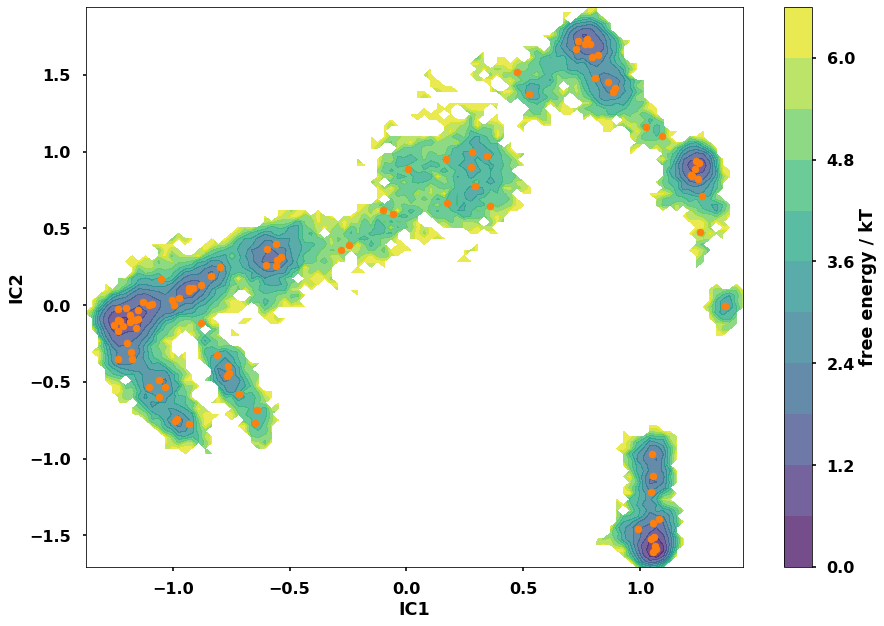

In [11]:
cluster = pyemma.coordinates.cluster_kmeans(tica_getoutput, k=100, max_iter=50, stride=5)

print(cluster.clustercenters.shape)

tica_in = np.load(f'tica_getoutput.npy', allow_pickle = True)
tica_cat = np.concatenate(tica_in).T

plt.figure(figsize=(5, 5))
IC_x, IC_y = 0, 1

pyemma.plots.plot_free_energy(tica_cat[IC_x], tica_cat[IC_y], cbar=True, cmap='viridis', ncontours=10, alpha=0.75)

plt.scatter(cluster.clustercenters[:, 0], cluster.clustercenters[:, 1], s=50, c='C1')
plt.xlabel('IC1')
plt.ylabel('IC2')
plt.tight_layout()
plt.savefig('WT_2_4M_FES_IC_h2b_clusters.svg', format="svg",transparent=True, dpi = 600)

In [12]:
### DISCRETIZER ###

# parameters for calculation
number_of_clusters = 100
max_iter = 50

# cluster using kmeans algorithm
cluster = pyemma.coordinates.cluster_kmeans(tica_getoutput, k=number_of_clusters, max_iter=max_iter)

cluster_getoutput = cluster.get_output()
cluster_dtrajs = cluster.dtrajs
cluster_centers = cluster.clustercenters

# SAVE
# kmeans is weird in pyemma, so we save a bunch of potentially relevant objects in case of data corruption
discretization_save_name = 'kmeans'
if SAVE:
    cluster_getoutput = cluster.get_output()
    cluster_dtrajs = cluster.dtrajs
    cluster_centers = cluster.clustercenters

    np.save(f'cluster_getoutput.npy', cluster_getoutput)
    np.save(f'cluster_dtrajs.npy', cluster_dtrajs)
    np.save(f'cluster_centers.npy', cluster_centers)

print('discretization complete')

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

discretization complete


In [13]:
### MSM ###
msm_lag = 50

msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, msm_lag)

# SAVE
# only time it is ok to use pyemma's save function
msm_save_name = 'msm'
if SAVE:
    msm.save(f'msm.h5',  overwrite=True)

print('------------------------------------------------------------------------')
print('MODEL COMPLETE')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
MODEL COMPLETE
------------------------------------------------------------------------


In [14]:
its = pyemma.msm.its(cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

estimating BayesianMSM:   0%|                                                                                 …

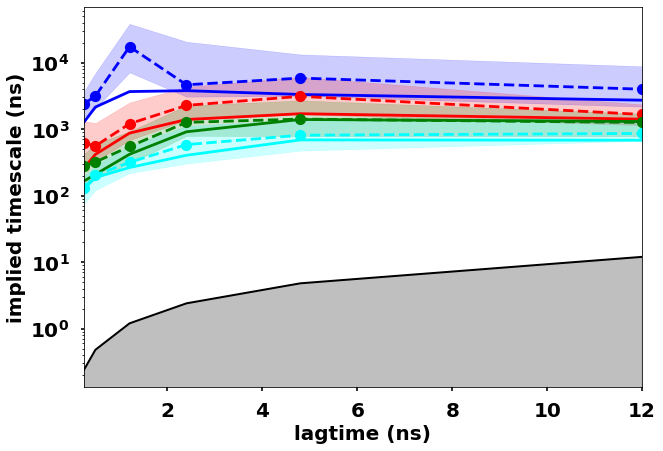

In [17]:
fig, ax = plt.subplots(figsize=(10,7))

# NOTE the 'its' object is in FRAMES (by design)
# pyemma requires specified 'dt' parameter for frame rate in ns
# 240 ps frames for this dataset, so 0.24 ns 
frame_rate_ns = 0.24

# pyemma's own plotting. works like pyplot
pyemma.plots.plot_implied_timescales(its, units='ns', dt=frame_rate_ns, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=14)

ax.set_xlabel('lagtime (ns)', fontsize = 20)
ax.set_ylabel('implied timescale (ns)', fontsize = 20)

plt.savefig('WT_2_4M_implied timescale_h2b_12us.svg', format="svg",transparent=True, dpi = 600)